In [2]:
import json
import gc
import os, glob
import numpy as np
from PIL import Image
from pprint import pprint
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# image_dataset_path = '/home/youngwoong/hdd/Image_Data/image_dataset'
# json_dataset_path = '/home/youngwoong/hdd/Image_Data/json_dataset'
# os.mkdir(image_dataset_path)
# os.mkdir(json_dataset_path)

In [4]:
# def unzip_file(path_type, data_path, zip_list):
#     cnt = 0
#     while cnt != 4:
#         cnt += 1
#         if cnt == 2:
#             path_type = '/2.Validation_Image/'
#             zip_list = [filename.replace('TL', 'VL') for filename in zip_list]
#         elif cnt == 3:
#             path_type = '/1.Training_Image/'
#             data_path = '원천데이터/'
#             zip_list = [filename.replace('VL', 'TS') for filename in zip_list]
#         elif cnt == 4:
#             path_type = '/2.Validation_Image/'
#             zip_list = [filename.replace('TS', 'VS') for filename in zip_list]
            
#         for zip_file in zip_list:
#             zip_path = f'/home/gbswhs/hdd/Image_Data/175.야생동물 활동 영상 데이터/01. 데이터{path_type}{data_path}{zip_file}'
#             !ls "$zip_path"
            
#             if cnt == 3 or cnt == 4:
#                 !unzip -uq "$zip_path" -d '/home/gbswhs/hdd/Image_Data/image_dataset'
#             else:
#                 !unzip -uq "$zip_path" -d '/home/gbswhs/hdd/Image_Data/json_dataset'

In [5]:
# path_type = '/1.Training_Image/'
# data_path = '라벨링데이터/'
# zip_list = ['TL_01.고라니.zip', 'TL_02.멧돼지.zip', 'TL_03.너구리.zip', 'TL_04.다람쥐.zip', 'TL_05.청설모.zip',
#             'TL_06.반달가슴곰.zip', 'TL_07.족제비.zip', 'TL_08.멧토끼.zip', 'TL_09.왜가리.zip',
#             'TL_10.중대백로.zip', 'TL_11.노루.zip']
# unzip_file(path_type, data_path, zip_list)

In [3]:
json_folder_path = 'C:\\Users\\yuncs\\Desktop\\test\\label\\'
image_folder_path = 'C:\\Users\\yuncs\\Desktop\\test\\img\\'
image_files = os.listdir(image_folder_path)
json_files = os.listdir(json_folder_path)
print(f"image_data : {len(image_files)}\njson_data : {len(json_files)}")

image_data : 40
json_data : 40


In [4]:
#with open('C:\\Users\\yuncs\\Desktop\\test\\label\\A01_F03_C074_C_200114_3001_20S_000001.061.json') as data_file:
  #local = json.load(data_file)
#pprint(local['annotations'])

with open('C:\\Users\\yuncs\\Desktop\\test\\label\\A02_F02_C081_C_211026_6002_20S_000010.235.json') as data_file:
  local = json.load(data_file)

data = {}
for id, i in enumerate(local['annotations']):
  print(i['category_id'])
  data[id] = []
  data[id].append(local['images'][0]['file_name'])
  data[id].append(id)

  print(data)

print(data[0][0])

2
{0: ['A02_F02_C081_C_211026_6002_20S_000010.235.jpg', 0]}
2
{0: ['A02_F02_C081_C_211026_6002_20S_000010.235.jpg', 0], 1: ['A02_F02_C081_C_211026_6002_20S_000010.235.jpg', 1]}
A02_F02_C081_C_211026_6002_20S_000010.235.jpg


In [5]:
json_dataset_files = 'C:\\Users\\yuncs\\Desktop\\test\\label\\'

In [6]:
json_files = []

for filename in os.listdir(json_dataset_files):
  if filename.endswith('.json'):
    json_files.append(os.path.join(json_dataset_files, filename))

In [7]:
all_json_files = json_files

category : inermis, count : 20
category : scrofa, count : 26


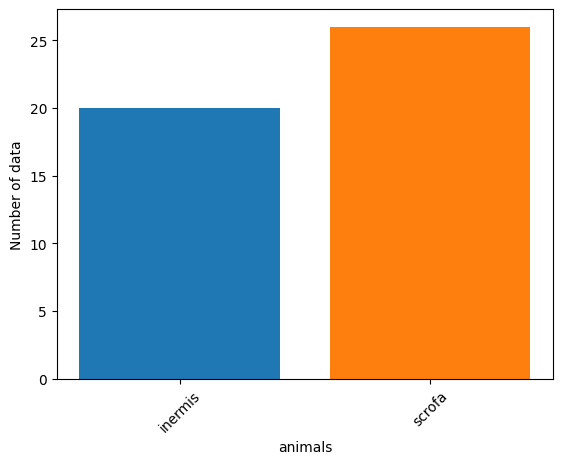

In [8]:
category_counts = {}

for json_file in all_json_files:
  with open(json_file, 'r') as f:
    data = json.load(f)

    annotations = data.get('annotations', [])
    for annotation in annotations:
      category_id = annotation.get('category_id', None)

      if category_id is not None:
        category_name = annotation.get('category_name', 'Unknown')
        category_counts[category_name] = category_counts.get(category_name, 0) + 1

for category, count in category_counts.items():
  plt.bar(category, count)
  plt.xlabel('animals')
  plt.ylabel('Number of data')
  plt.xticks(rotation=45)
  print(f"category : {category}, count : {count}")

In [9]:
class CustomDataset(Dataset):
  def __init__(self, root, split='train', transform=None, target_transform=None):
    self.data = {}
    self.classes = []
    self.transform = transform
    self.target_transform = target_transform 

    img_path = os.path.join(root, "img")
    label_path = os.path.join(root, "label")

    data_count = 0
    for (path, dir, files) in os.walk(label_path):
      for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.json':
          full_path = path + '\\' + filename
          # json 파싱
          with open(full_path, "r", encoding="utf8") as fjson:
                contents = fjson.read()
                json_data = json.loads(contents)
          for obj in json_data['annotations']:
            class_id = obj['category_id']-1
            self.classes.append(class_id) # 클래스 정의
            img_name = img_path + '\\' + json_data['images'][0]['file_name']
            self.data[data_count] = []
            self.data[data_count].append(img_name) # 데이터 정의
            self.data[data_count].append(int(obj['bbox'][0][0])) # left
            self.data[data_count].append(int(obj['bbox'][0][1])) # top
            self.data[data_count].append(int(obj['bbox'][1][0])) # right
            self.data[data_count].append(int(obj['bbox'][1][1])) # bottom
            data_count += 1

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_info = self.data[idx]
    image_path = image_info[0]
    image = Image.open(image_path)
    bbox = (image_info[1], image_info[2], image_info[3], image_info[4])
    cropped_img = image.crop(bbox) 
    
    if self.transform is not None:
      cropped_img = self.transform(cropped_img)
    
    label = self.classes[idx]
    if self.target_transform is not None:
        label = self.target_transform(label)
    
    return cropped_img, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
all_dataset = CustomDataset("/Image_Data", transform=transform)

In [72]:
print(len(all_dataset.data))

46


In [13]:
train_size = int(0.8 * len(all_dataset))
val_size = len(all_dataset) - train_size

In [14]:
train_dataset, val_dataset = random_split(all_dataset, [train_size, val_size])

In [15]:
batch_size=5
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [73]:
num_class = len(val_dl)
print(num_class)

2


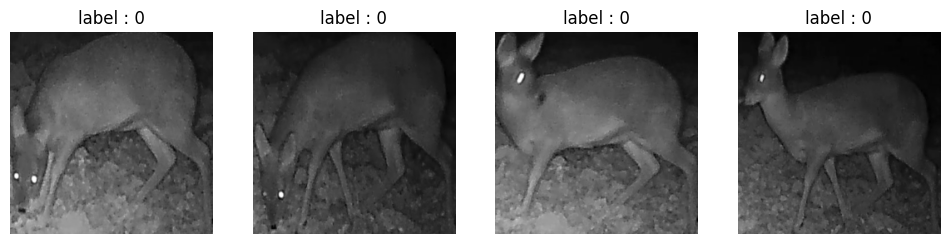

In [66]:
num_samples_to_display = 4
sample_indices = np.random.choice(len(train_dl), num_samples_to_display, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
  image, label = all_dataset[idx]
  image = image.permute(1, 2, 0)

  plt.subplot(1, num_samples_to_display, i + 1)
  plt.imshow(image)
  plt.title(f"label : {label}")
  plt.axis('off')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch import optim

import copy
import time

from sklearn.utils.class_weight import compute_class_weight

In [19]:
class BottleNeck(nn.Module):
  expansion = 4 # 출력 계수를 늘리는 비율
  Cardinality = 32 # 그룹
  Basewidth = 64 # 컨볼루션 레이어의 입력 채널의 기본 너비
  Depth = 4 # 레이어의 깊이

  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    C = BottleNeck.Cardinality
    D = int(BottleNeck.Depth * out_channels / BottleNeck.Basewidth)

    self.conv_residual = nn.Sequential(
        nn.Conv2d(in_channels, C * D, 1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(C*D),
        nn.ReLU(),
        nn.Conv2d(C*D, C*D, 3, stride=stride, padding=1,
                  groups=BottleNeck.Cardinality, bias=False),
        nn.BatchNorm2d(C*D),
        nn.ReLU(),
        nn.Conv2d(C*D, out_channels * BottleNeck.expansion, 1, stride=1,
                  padding=0, bias=False),
        nn.BatchNorm2d(out_channels * BottleNeck.expansion)
    )
    self.conv_shortcut = nn.Sequential()

    if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
      self.conv_shortcut = nn.Conv2d(in_channels, out_channels *
                                     BottleNeck.expansion, 1, stride=stride, padding=0)
  def forward(self, x):
    x = self.conv_residual(x) + self.conv_shortcut(x) # 잔여 연결
    return x

In [20]:
class ResNext(nn.Module):
  def __init__(self, nblocks, num_classes=None, init_weights=True):
    super().__init__()
    self.init_weights=init_weights
    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, 7, stride=2, padding=2, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2, padding=1)
    )
    self.conv2 = self._make_res_block(nblocks[0], 64, 1)
    self.conv3 = self._make_res_block(nblocks[1], 128, 2)
    self.conv4 = self._make_res_block(nblocks[2], 256, 2)
    self.conv5 = self._make_res_block(nblocks[3], 512, 2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(512 * BottleNeck.expansion, num_classes) # fully connected 레이어

    if self.init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.linear(x)
    return x

  def _make_res_block(self, nblock, out_channels, stride):
    strides = [stride] + [1] * (nblock-1)
    res_block = nn.Sequential()
    for i, stride in enumerate(strides):
      res_block.add_module('dens_layer_{}'.format(i),
BottleNeck(self.in_channels, out_channels, stride))
      self.in_channels = out_channels * BottleNeck.expansion
    return res_block

  def _initialize_weights(self):
       for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')# fan_out 모드는 가중치의 행을 사용하여 초기화
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

In [21]:
num_classes=len(np.unique(all_dataset.classes))

def ResNext50():
  return ResNext([3, 4, 6, 3], num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 244, 244)).to(device)
model = ResNext50().to(device)

output = model(x)
print('output size: ', output.size())

output size:  torch.Size([3, 2])


In [79]:
class_weights = compute_class_weight('balanced', classes = np.unique(all_dataset.classes), y=all_dataset.classes)
class_weights=torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights)

tensor([1.1500, 0.8846], device='cuda:0')


In [80]:
loss_func = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
opt = optim.SGD(model.parameters(), lr=0.01)

In [81]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10) # 현재 설정한 개수 만큼 에폭 동안 개선이 없으면 조정함
#  학습률을 동적으로 조정해줌 손실이 감소할 때 학습률을 감소시켜줌

In [82]:
def get_lr(opt):
  for param_group in opt.param_groups: # 최적화기의 파라미터 그룹들을 나타내는 리스트를 반환
    return param_group['lr'] # 각 파라미터의 현재 학습률을 가져옴

In [83]:
def metric_batch(output, target):
  pred = output.argmax(1, keepdim=True) # 예측된 클래스 선택
  corrects = pred.eq(target.view_as(pred)).sum().item() # 정답과 일치하는 샘플 수 계산
  return corrects

In [84]:
def loss_batch(loss_fucn, output, target, opt=None):
  loss_b = loss_func(output, target) # 손실 계산
  metric_b = metric_batch(output, target) # 메트릭 계산

# optimizer 업데이트
  if opt is not None:
    opt.zero_grad() # grad 초기화
    loss_b.backward() # 역전파
    opt.step() # 파라미터 업데이트

  return loss_b.item(), metric_b

In [90]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):    
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        #print(output)
        #print(yb)

        # 각 배치에 대한 손실과 메트릭 계산
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # 전체 에폭에 대한 손실 누적
        running_loss += loss_b

        # 메트릭이 제공되는 경우 전체 에폭에 대한 메트릭 누적
        if metric_b is not None:
            running_metric += metric_b
        # sanity_check가 True인 경우 하나의 배치만 사용하도록 설정
        if sanity_check is True:
            break

    # 전체 에폭에 대한 평균 손실과 메트릭 계산
    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

In [86]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # 최상의 손실을 양의 무한대로 초기화
    best_loss = float('inf')
    # 모델 가중치를 최상의 가중치로 deepcopy
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        # 현재 학습률 획득
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        # 훈련 단계
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # 검증 단계
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        # 검증 손실이 좋아지면 최상의 모델 가중치 저장
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
        # 학습률 조정
        lr_scheduler.step(val_loss)
        # 학습률이 조절되면 최상의 모델 가중치로 복원
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [87]:
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False, # 정상성 검사 여부
    'lr_scheduler':lr_scheduler,
    'path2weights':'/Image_Data/weights.pt'
}
def createFolder(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSerror:
    print('Error')
createFolder('./models')

In [88]:
gc.collect()

394

In [93]:
model, loss_hist, metric_hist = train_val(model, params_train) # 학습

Epoch 0/99, current lr= 1.0000000000000004e-08
train loss: nan, val loss: nan, accuracy: 50.00, time: 0.0205 min
----------
Epoch 1/99, current lr= 1.0000000000000004e-08
train loss: nan, val loss: nan, accuracy: 50.00, time: 0.0378 min
----------
Epoch 2/99, current lr= 1.0000000000000004e-08
train loss: nan, val loss: nan, accuracy: 50.00, time: 0.0558 min
----------
Epoch 3/99, current lr= 1.0000000000000004e-08
train loss: nan, val loss: nan, accuracy: 50.00, time: 0.0729 min
----------
Epoch 4/99, current lr= 1.0000000000000004e-08


KeyboardInterrupt: 

In [ ]:
class LayerResult:
    def __init__(self, payers, layer_index):
        self.hook = payers[layer_index].register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output.cpu().data.numpy()
    
    def unregister_forward_hook(self):
        self.hook.remove()

In [ ]:
result = LayerResult(model.features, 0)
img = Image.open('./Image_Data/test_img/12274_37214_4316.jpg')
img = transforms.ToTensor()(img).unsqueeze(0)
model(img.cuda())
activations = result.features

In [ ]:
num_epochs = params_train['num_epochs']

plt.title('Train_Val_Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Train_Val_Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label=['val'])
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(8,8)
for row in range(8):
    for column in range(8):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*8+column])
plt.show()